In [1]:
from time import time as tm
from pathlib import Path
import numpy as np
from plot_event_example import plot_example
from dunedn.inference.hitreco import DnModel
from dunedn.inference.analysis import analysis_main
from dunedn.utils.utils import load_runcard

In [2]:
modeltype = "uscg"
version = "v08"
basedir = Path("../../output/tmp")
outdir = basedir / "models/onnx"
ckpt = Path(f"../saved_models/{modeltype}_{version}")  # folder with checkpoints
setup = load_runcard(basedir / "cards/runcard.yaml") # settings runcard

Extracting data into ../../output/tmp/models/onnx...


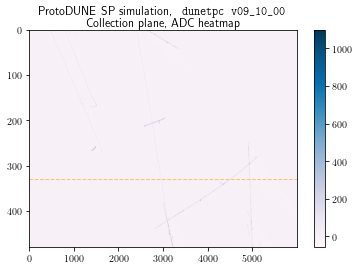

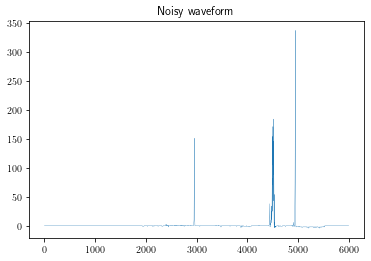

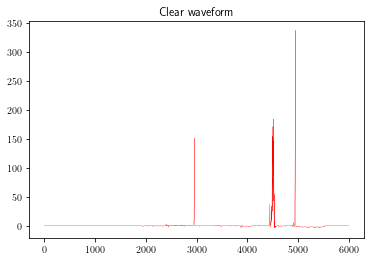

In [3]:
# data loading
print(f"Extracting data into {outdir}...")
!mkdir -p $outdir
!tar -xf dunetpc_inspired_v09_p2GeV_rawdigits.tar.gz -C $outdir

plot_example(outdir, with_graphics=True)

In [13]:
input_path = outdir / "p2GeV_cosmics_inspired_rawdigit_evt8.npy"
evt = np.load(input_path)[:, 2:]
print(f"Loaded event at {input_path}")

Loaded event at ../../output/tmp/models/onnx/p2GeV_cosmics_inspired_rawdigit_evt8.npy


In [5]:
# inference function
def inference(model, evt, fname):
    """Makes inference on event and computes time.

    Saves the output file to `fname`.

    Parameters
    ----------
    model: DnModel
        The pytorch or onnx based model.
    evt: np.ndarray
        The input raw data.
    fname: Path
        The output file name.

    Returns
    -------
    inference_time: float
        The elapsed time for inference.
    """
    start = tm()
    evt_dn = model.predict(evt)
    inference_time = tm() - start

    # add info columns
    nb_channels, _ = evt_dn.shape
    channels_col = np.arange(nb_channels).reshape([-1, 1])
    event_col = np.zeros_like(channels_col)
    evt_dn = np.concatenate([event_col, channels_col, evt_dn], axis=1)

    # save pytorch inference
    np.save(fname, evt_dn)
    return inference_time

In [6]:
# PyTorch model loading
model = DnModel(setup, modeltype, ckpt)
print(f"Loaded model from {ckpt} folder")

[INFO] (dunedn.uscg) Loading weights at ../saved_models/uscg_v08/induction/uscg_v08_dn_induction.pth
[INFO] (dunedn.uscg) Loading weights at ../saved_models/uscg_v08/collection/uscg_v08_dn_collection.pth


Loaded model from ../saved_models/uscg_v08 folder


In [15]:
# PyTorch inference
target_path = outdir / "p2GeV_cosmics_inspired_rawdigit_noiseoff_evt8.npy"
reco_path = outdir / "pytorch_inference_results.npy"
pytorch_time = inference(model, evt, reco_path)
print(f"PyTorch inference done in {pytorch_time}s")

# compute metrics
analysis_main(reco_path, target_path)

(15360, 6002) (15360, 6002) (15360, 6002)


[INFO] (dunedn.analysis) Prediction metrics:
      ssim: 0.701 +/- 0.047
      psnr: 63.487 +/- 2.657
       MSE: 0.413 +/- 0.090
      IMAE: 871.416 +/- 206.164


In [ ]:
# export model to ONNX format
# create model save directory
onnx_save_folder = outdir.joinpath(f"saved_models/{modeltype}_{version}")
onnx_save_folder.mkdir(parents=True, exist_ok=True)
model.onnx_export(onnx_save_folder)

model_onnx = DnModel(setup, modeltype, onnx_save_folder, should_use_onnx=True)

In [ ]:
# ONNX inference
fname = outdir / "onnx_inference_results.npy"
onnx_time = inference(model_onnx, evt, fname)
print(f"ONNX inference done in {onnx_time}s")

# compute metrics
evt_dn = np.load(fname)
analysis_main(evt_dn, evt)